In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train["year_month"] = train["year"].astype(str) + "_" + train["month"].astype(str)
test["year_month"] = test["year"].astype(str) + "_" + test["month"].astype(str)

In [10]:
train_area_mean = train.area.mean()
test_area_mean = test.area.mean()
area_mean = (train_area_mean + test_area_mean) / 2
train["area"] = train["area"].fillna(area_mean)
test["area"] = test["area"].fillna(area_mean)

train["cover_area"] = train.cover * train.area
train["cover_area_log"] = np.log1p(train['cover_area'])

max : 3.713572
min : 0.000000
Skewness: 1.030917
Kurtosis: -0.204865


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


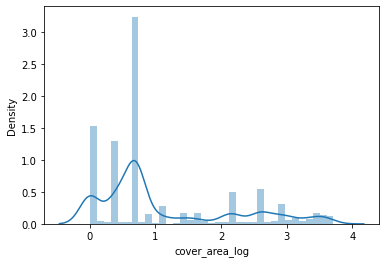

In [11]:
sns.distplot(train["cover_area_log"])

print("max : %f" %train["cover_area_log"].max())
print("min : %f" %train["cover_area_log"].min())
print('Skewness: %f' %train["cover_area_log"].skew())  #歪度
print('Kurtosis: %f' %train["cover_area_log"].kurt())  #尖度

In [12]:
train["adv_flag"] = 0
test["adv_flag"] = 1

df = pd.concat([train,test]).reset_index(drop=True)

In [13]:
train_missing_50 = train_missing[train_missing.percent<0.5].index
test_missing_50 =  test_missing[test_missing.percent<0.5].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_50) & set(test_missing_50)
features = set(features) - set(categorical_features) 

In [14]:
display(train[features])

,MAX_IF_2002,MIN_Ferric_Oxides_2014,MIN_CRI550_2015,MIN_Cirededge_2013,MAX_Cirededge_2014,MED_Ferric_Oxides_2003,MED_B12,MED_EVI_2005,MIN_Cigreen_2003,MED_Blue_2015,...,MAX_DVIMSS_2009,MED_TIRS1_2005,MED_Gossan_2003,MAX_SLAVI_2019,MAX_NormG_2015,MIN_Cigreen_2001,MAX_Chlred_edge_2015,MED_Green_2020,MAX_Blue_2008,MIN_D678_500_2013
0,NaN,0.064100,-0.023786,-0.619993,-0.443735,0.087063,115.195236,0.091279,-0.871023,47.264137,...,0.556784,8.594110,0.036568,25607.252539,0.659553,-0.796401,3.745741,32.292114,52.186863,-49.062395
1,NaN,0.075444,-0.011069,-0.740350,-0.681103,NaN,559.898498,0.193357,NaN,63.922331,...,NaN,8.788394,NaN,4150.415075,0.574648,-0.716131,4.290752,56.621244,48.877384,-34.387272
2,2.770231,0.095308,-0.007679,-0.686226,-0.508214,0.137902,1114.768311,0.108556,-0.749122,66.075657,...,85.334372,8.385872,0.118045,494.961561,0.648409,-0.801425,3.687411,41.529869,55.147869,-43.246603
3,NaN,0.091349,-0.017842,-0.651875,-0.561259,NaN,400.787994,NaN,NaN,58.518513,...,NaN,NaN,NaN,147.907781,0.677397,-0.776426,3.641893,42.985603,NaN,-55.105478
4,NaN,0.078648,-0.011780,-0.628198,-0.557402,NaN,345.600464,NaN,NaN,81.286495,...,NaN,NaN,NaN,96.308079,0.694337,-0.821655,2.756829,44.311539,NaN,-70.220974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,2.802467,0.109071,-0.018727,-0.534064,-0.154347,0.107873,385.598175,0.052845,-0.518472,51.337967,...,31.162159,8.820515,0.121156,5740.141447,0.550143,-0.641953,1.823489,38.308187,59.877560,-48.605171
14136,NaN,0.076110,-0.013202,-0.773093,-0.303423,NaN,671.369690,NaN,NaN,64.720165,...,NaN,NaN,NaN,221.416265,0.676380,-0.561213,3.821062,56.599417,60.914772,-53.558104
14137,NaN,0.067165,-0.012542,-0.634301,-0.422233,NaN,206.296234,0.076737,NaN,61.555771,...,14.317187,8.587133,NaN,640.937413,0.705026,NaN,3.851664,32.298449,72.799942,-56.778391
14138,NaN,0.133121,-0.007164,-0.632015,-0.425141,NaN,578.266724,NaN,NaN,102.457336,...,NaN,NaN,NaN,5577.542925,0.563821,-0.713751,2.637785,113.485336,NaN,-48.166023


In [15]:
tr_mesh = train.mesh20.value_counts().index
te_mesh = test.mesh20.value_counts().index

test_only_mesh = list(set(te_mesh)-set(tr_mesh))
test_mesh = list(set(te_mesh)-set(test_only_mesh))

In [16]:
def get_mesh_values(df):
  _df = df["mesh20"].str.split('_').apply(pd.Series).astype(float)
  _df.columns = ["mesh20_left","mesh20_right"]
  df["mesh20_left"] = _df["mesh20_left"].astype(int)
  df["mesh20_right"] = _df["mesh20_right"].astype(int)
  return df

In [17]:
train = get_mesh_values(train)
test = get_mesh_values(test)

In [18]:
tr_mesh_l = train.mesh20_left.value_counts().index
te_mesh_l = test.mesh20_left.value_counts().index

tr_mesh_r = train.mesh20_right.value_counts().index
te_mesh_r = test.mesh20_right.value_counts().index

print(set(te_mesh_l)-set(tr_mesh_l))
print(set(te_mesh_r)-set(tr_mesh_r))

set()
set()


## Model

In [19]:
#!pip install iterative-stratification

In [20]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [21]:
class CFG:
  ver=25
  model="lightgbm"
  n_folds=4
  trn_fold=[0, 1, 2, 3]
  seed=42
  target_cols1="adv_flag"
  target_cols2="cover"
  boosting_type="gbdt"
  fold_target1="adv_flag"
  fold_target2="cover_area_log"
  fold_target3="cover"

In [22]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df,fold_target, isFlag=False):
  if isFlag:
    Fold = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target], groups=df["mesh20"])):
        df.loc[val_index, 'fold'] = int(n)
  else:
    Fold = GroupKFold(n_splits=CFG.n_folds)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target], groups=df["year_month"])):
      df.loc[val_index, 'fold'] = int(n)
  df['fold'] = df['fold'].astype(int)
  display(df.groupby('fold').size())
  return df

In [23]:
def get_score(labels, preds, isFlag=False):
  if isFlag:
    f1score = f1_score(labels, preds)
    pscore = precision_score(labels, preds)
    rscore =recall_score(labels, preds)
    print(f"F1 Score : {f1score}")
    print(f"Precision Score : {pscore}")
    print(f"Recall Score {rscore}")
  else:
    rmse = np.sqrt(mean_squared_error(labels, preds))
    print(f"RMSE {rmse}")

In [24]:
features = list(features)
features.remove('id')
features.remove('area')
features.remove("year")
features.remove("month")

In [25]:
params1 = {
        'objective': "binary",
        'metric': 'binary_logloss',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

params2 = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

In [26]:
def get_pred(df, test, fold_target, target_cols, model, isFlag=False):
  if isFlag:
    pred_name = "flag"
    train = get_fold(df, fold_target, isFlag=True)
  else:
    pred_name = ""
    train = get_fold(df, fold_target, isFlag=False)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train['fold'] != fold]
      valid_folds = train[train['fold'] == fold]

      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              verbose = 200,
              early_stopping_rounds=50)
      
      if isFlag:
        pred = model.predict(valid_X)
        predict_proba = model.predict_proba(valid_X)
        valid_folds["Zscore"] = predict_proba[:,1]
        valid_folds[f"{pred_name}_pred"] = pred
      else:
        valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)
        test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"{pred_name}_pred"], isFlag)

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"{pred_name}_pred"], isFlag)
  if isFlag:
    return oof_df
  else:
    return oof_df,  test_preds

In [27]:
# 傾向スコアマッチング関数
def matching(result1, z_col='Zscore', tr_col="adv_flag", match_id='id'):
    '''
    result1: 介入変数、傾向スコア、共変量のデータフレーム
    '''
    # キャリパー設定
    caliper = result1[z_col].std()*0.2

    # 処置群抽出
    Tr = result1[result1[tr_col]>0][[match_id, z_col]].copy().reset_index(drop=True)
    Tr.index = Tr[match_id]
    # 対照群抽出
    Ctl = result1[result1[tr_col]==0][[match_id, z_col]].copy().reset_index(drop=True)
    Ctl.index = Ctl[match_id]
    
    Ctl_vals = np.copy(Ctl[z_col].to_numpy()) # 配列化
    Ctl_ids = np.copy(Ctl.index.to_numpy()) # 配列化
    Tr_vals_dict = Tr[z_col].sort_values(ascending=False).to_dict() # 処置群の傾向スコアで降順にして辞書化

    # マッチングを実施していく
    match_results = [] # 結果を入れる箱
    for i, (cid, tr_val) in tqdm(enumerate(Tr_vals_dict.items())):
        # cid:user_id, tr_val:傾向スコア
        # argminで処置群と最も傾向スコアの差が小さい対照群のインデックス番号取得
        nearId = np.abs(Ctl_vals - tr_val).argmin()
        # 傾向スコアの差がキャリパーより大きかった場合、マッチングしない
        if np.abs(tr_val-Ctl_vals[nearId])>caliper:
            continue
        # 傾向スコアの差がキャリパーより小さかった場合、マッチングした者同士をリストに格納
        match_results.append([cid, Ctl_ids[nearId], tr_val, Ctl_vals[nearId]])
        # 次のマッチングで重複してマッチングしないように対照群のスコアを-9999に置き換える
        np.put(Ctl_vals, [nearId], -9999)

    # リストをdf化
    match_results_df = pd.DataFrame(match_results, columns=['Tr', 'Ctl', 'Tr_zscore', 'Ctl_zscore'])
    match_results_df['diff'] = np.abs(match_results_df['Tr_zscore']-match_results_df['Ctl_zscore'])
    print(match_results_df['diff'].max())
    return match_results_df

In [28]:
#model1 = lgb.LGBMClassifier(**params1)
#flag_oof = get_pred(df, test, CFG.fold_target1, CFG.target_cols1, model1, isFlag=True)

In [29]:
#match_results_df = matching(flag_oof, z_col='Zscore', tr_col='adv_flag', match_id='id')
#display(match_results_df)

In [30]:
#match_id = match_results_df.Ctl.tolist()
#match_train = train[train["id"].isin(match_id)].reset_index(drop=True)
#display(match_train)

fold
0    3536
1    3536
2    3533
3    3535
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[98]	valid_0's rmse: 0.258224
RMSE 0.2582240507606907
===============  FOLD : 1  

<ipython-input-26-3bef420f24b8>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[8]	valid_0's rmse: 0.156795
RMSE 0.1567952290534081
===============  FOLD : 2  ===============


<ipython-input-26-3bef420f24b8>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.186674
Early stopping, best iteration is:
[341]	valid_0's rmse: 0.185976


<ipython-input-26-3bef420f24b8>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.18597591631973526
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[24]	valid_0's rmse: 0.166245


<ipython-input-26-3bef420f24b8>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.1662447632957824


,feature,importance
2532,Date_Acquired,0.006299
1940,sst_ymd,0.005591
1479,hist_warm_sst,0.005237
2993,depth,0.004600
805,sst_diff,0.004459
1955,warm_sst,0.003822
3110,MIN_GARI,0.003539
1676,fetch,0.003255
1745,TIRS2,0.002902
850,VARIgreen,0.002902


RMSE 0.19589219997838692


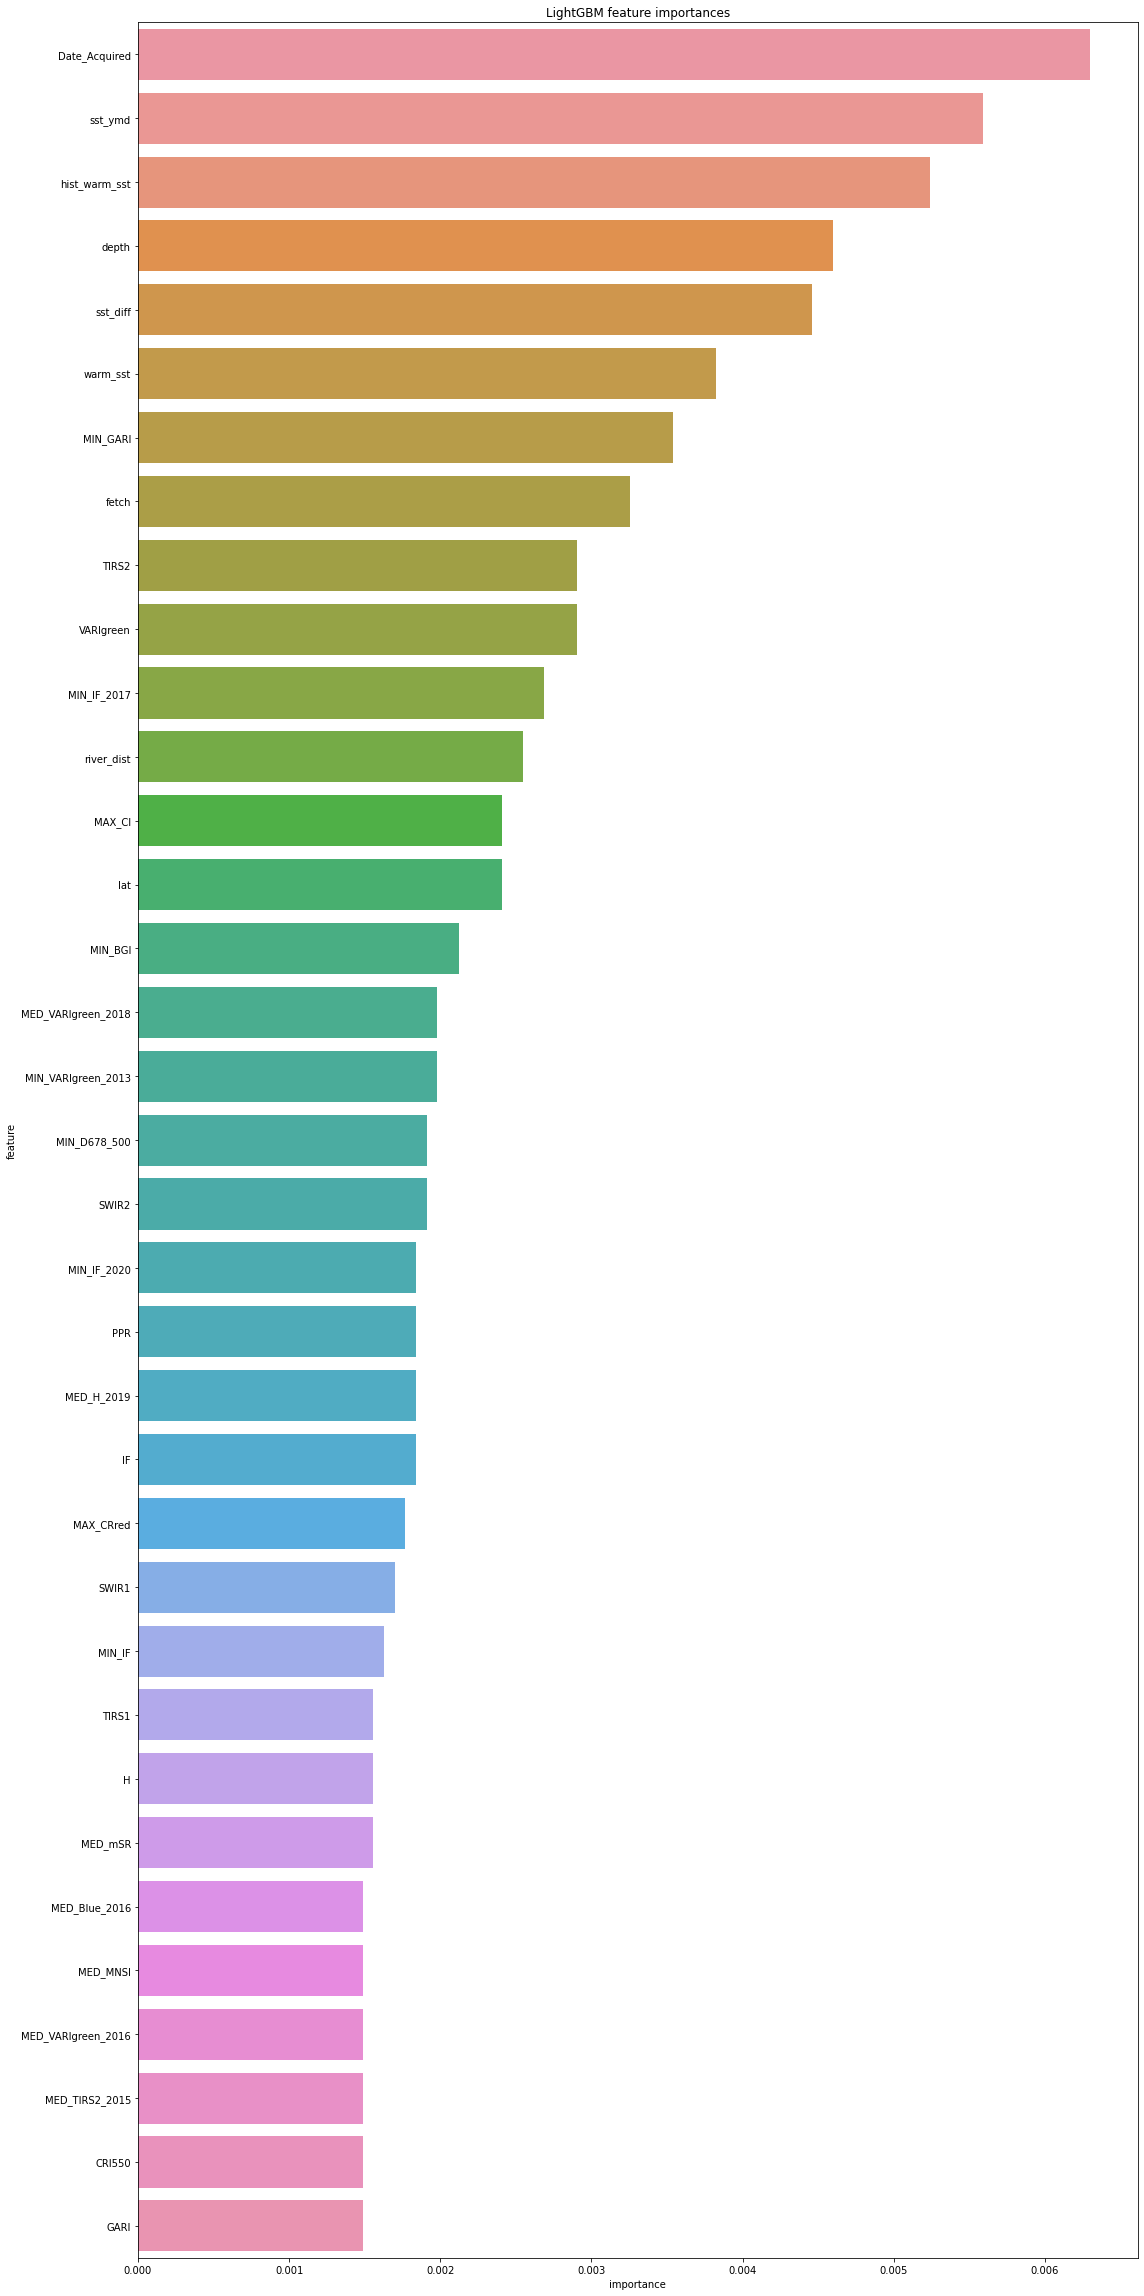

In [31]:
model2 = lgb.LGBMRegressor(**params2)
oof_df, test_pred = get_pred(train, test, CFG.fold_target3, CFG.target_cols2, model2)

In [32]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = _oof["_pred"]
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.1958749996519021


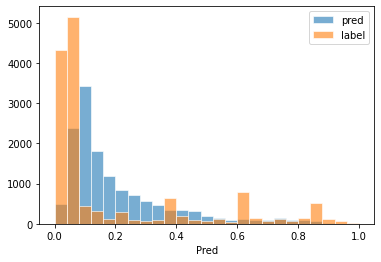

In [33]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [34]:
pred_df = test.copy()
pred_df["pred"] = np.mean(test_pred, axis=1)
pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,year_month,adv_flag,mesh20_left,mesh20_right,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,4.297234,926.905329,1.669992,0.194766,3624_20,2002.0_12.0,1,3624,20,0.085566
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,2.263106,57.661693,4.274851,-79.273275,3624_20,2010.0_7.0,1,3624,20,0.063708
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,2.099250,42.672829,5.655713,-2.061417,3927_23,2004.0_2.0,1,3927,23,0.077780
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-10.433323,45.061952,1.546086,-14.527890,3927_11,2010.0_8.0,1,3927,11,0.073897
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,2.563503,80.374689,1.827876,-6.335208,3725_01,2019.0_10.0,1,3725,1,0.328251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,3.633575,60.936945,3.053976,-28.354402,4027_03,2019.0_9.0,1,4027,3,0.135894
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,2.495430,75.231230,3.946128,-2.112646,3624_20,2010.0_11.0,1,3624,20,0.076997
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,4.403977,117.513676,1.904304,0.601280,3927_23,2004.0_2.0,1,3927,23,0.218577
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,2.203933,121.654726,2.282056,-2.029225,3623_03,2011.0_4.0,1,3623,3,0.209440


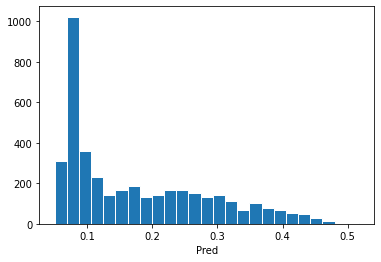

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,year_month,adv_flag,mesh20_left,mesh20_right,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,4.297234,926.905329,1.669992,0.194766,3624_20,2002.0_12.0,1,3624,20,0.085566
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,2.263106,57.661693,4.274851,-79.273275,3624_20,2010.0_7.0,1,3624,20,0.063708
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,2.099250,42.672829,5.655713,-2.061417,3927_23,2004.0_2.0,1,3927,23,0.077780
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-10.433323,45.061952,1.546086,-14.527890,3927_11,2010.0_8.0,1,3927,11,0.073897
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,2.563503,80.374689,1.827876,-6.335208,3725_01,2019.0_10.0,1,3725,1,0.328251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,3.633575,60.936945,3.053976,-28.354402,4027_03,2019.0_9.0,1,4027,3,0.135894
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,2.495430,75.231230,3.946128,-2.112646,3624_20,2010.0_11.0,1,3624,20,0.076997
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,4.403977,117.513676,1.904304,0.601280,3927_23,2004.0_2.0,1,3927,23,0.218577
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,2.203933,121.654726,2.282056,-2.029225,3623_03,2011.0_4.0,1,3623,3,0.209440


In [35]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)